#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data and Cleanup](#eda_retrieval)
#### 3. [Handling of NAs](#eda_na)
#### 4. [Data Cleanup](#data_cleanup)
#### 5. [Feature Reduction](#feature_reduction)
#### 5. [Feature Reduction](#XGBoost)
#### 5. [Feature Reduction](#SMOTE_XGBoost)



### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [1]:
!pip install seaborn --upgrade

!pip install cmake

!pip install xgboost

!pip install scikit-learn

!pip install imblearn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [35]:
##import libraries required for analysis
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 
import xgboost as xgb
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

### <a name="eda_retrieval"></a>Retreival of Data and Cleanup
We need to retrieve all the CSVs that have been cleaned by our team and then merge them together based on the ID field.  There's also some minor carpentry work we need to do before running any models

In [11]:
file_path = "/dsa/groups/casestudy2023su/team03/merged_data/mros_merged_clean.csv"
merged_df = pd.read_csv(file_path)
merged_df.columns = merged_df.columns.str.upper()

In [6]:
merged_df.describe()

,B1TRD,B1ITD,B1FND,B1L1D,B1L3D,B1TBD,B1HDD,B1LAD,B1RAD,B1LRD,...,RADIALPULSE_MEAS1,BMI,HEIGHTCHANGEFROM25,WEIGHTCHANGEFROM25,FAFXN,FAFXNT,GIAGE1,FAFXN_BIN,FAFXNT_BIN,OUTLIER
count,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,...,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000,5994.000000
mean,0.764990,1.111712,0.784170,0.979764,1.098752,1.167219,2.132447,0.848691,0.861511,0.706571,...,64.349891,27.378324,3.705292,10.339891,0.432432,0.343577,73.657658,0.253420,0.214715,0.899900
std,0.127367,0.166538,0.128116,0.176903,0.207320,0.126578,0.332499,0.091894,0.092162,0.135757,...,9.989382,3.829940,2.960090,11.375341,1.002012,0.813297,5.872264,0.435006,0.410659,0.436133
min,0.167047,0.389357,0.272729,0.298691,0.382238,0.764788,1.056920,0.515547,0.515601,0.443625,...,36.000000,17.211000,-30.180000,-42.393700,0.000000,0.000000,64.000000,0.000000,0.000000,-1.000000
25%,0.677239,0.998989,0.696196,0.859821,0.955975,1.083122,1.905628,0.791598,0.804045,0.636937,...,58.000000,24.777850,1.970000,2.994512,0.000000,0.000000,69.000000,0.000000,0.000000,1.000000
50%,0.758539,1.104805,0.773544,0.968030,1.081870,1.157550,2.113950,0.843987,0.856622,0.691454,...,64.000000,26.905750,3.590000,9.365350,0.000000,0.000000,73.000000,0.000000,0.000000,1.000000
75%,0.847302,1.221518,0.860129,1.086195,1.219765,1.241125,2.339317,0.898742,0.913262,0.751444,...,70.000000,29.490625,5.240000,17.125600,1.000000,0.000000,78.000000,1.000000,0.000000,1.000000
max,1.699030,1.984450,1.598350,1.976850,2.245680,2.046580,4.695200,1.945820,2.139360,4.667740,...,198.000000,50.668700,30.870000,69.257700,12.000000,12.000000,100.000000,1.000000,1.000000,1.000000


### <a name="eda_na"></a>Handling of NAs

The handling of NAs is now being done upstream so we're in good shape!

### <a name="data_cleanup"></a>Data Cleanup
In order to do my feature reduction, we're going to need to perform some more carpentry.  First, let's look at what non-numeric values we have and then and then determine whether  one-hot encoding is necessary.

In [12]:
merged_df["GIEDUC"] = merged_df["GIEDUC"].str.extract(r'^(\d+)', expand=False).astype(int)
merged_df["GIERACE"] = merged_df["GIERACE"].str.extract(r'^(\d+)', expand=False).astype(int)

### <a name="feature_reduction"></a>Feature Reduction

### Removal of Highly Correlated Features

If two or more columns are highly correlated, you can remove one of them since they provide redundant information. Below, we're calcuating a correlation matrix and then subsequently dropping columns with a high correlation coefficient.

In this case, we're dropping any features that have a greater than **.85** correlation

This is now being done upstream, no need to do it again!

### Recursive Feature Elimintation

Since the number of columns still remaining is still higher than we want to work with, we'll use now Recursive Feature Elimination by training a Random Forest model and removing the least important feature at each iteration.

In [17]:
#split into X and y by dropping target variables from our X variables and using one target at a time for y variable. Also used get_dummies to transform some categorical features.
X = pd.get_dummies(merged_df.drop(['FAFXN', 'FAFXNT', 'FAFXN_BIN', 'FAFXNT_BIN'], axis=1)) 
y = merged_df['FAFXNT_BIN'].astype(int)

#creating initial temp split of 10% for testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#second split of 10% for validation... leaving us with 80% for training.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42) # 0.1111 * 0.9 = 0.1

In [18]:
# Display the count of each class in the binary target
print(y.value_counts())

0    4707
1    1287
Name: FAFXNT_BIN, dtype: int64


### <a name="XGBoost"></a>XGBoost Proof of Concept

In [19]:
train_data = xgb.DMatrix(data=X_train, label=y_train)
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}
bst = xgb.train(param, train_data)


In [20]:
# Make predictions on the test set
test_data = xgb.DMatrix(data=X_test)
predictions = bst.predict(test_data)

# Evaluate the performance
from sklearn.metrics import roc_auc_score, accuracy_score

auc_score = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))

print(f"AUC: {auc_score}")
print(f"Accuracy: {accuracy}")


AUC: 0.6247963264701526
Accuracy: 0.78


In [22]:
# Convert predictions to binary 0 or 1
binary_predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       471
           1       0.44      0.09      0.14       129

    accuracy                           0.78       600
   macro avg       0.62      0.53      0.51       600
weighted avg       0.72      0.78      0.72       600



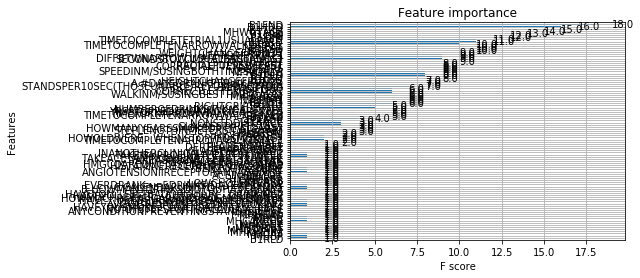

In [23]:
# Plot feature importance
plot_importance(bst)
plt.show()

In [26]:
# Get feature importance
importance = bst.get_score(importance_type='gain')

# Convert into a pandas dataframe
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Score': list(importance.values())
})

# Sort by the score in descending order
importance_df = importance_df.sort_values(by='Score', ascending=False)

# Display the importance_df dataframe
print(importance_df)


                             Feature      Score
0                              B1TRD  15.288112
37                            FFFX50  10.934348
14                             B1RLD   9.853963
2                              B1FND   9.442590
35                           MHHGTCM   9.388427
..                               ...        ...
55    HAVE…USEDCHEWINGTOBACCO/SNUFF?   3.495409
51  HAVEYOUSMOKE…100CIGARETTES…LIFE?   2.853195
58    HAVEYOU…FELT…CUTDOWN…DRINKING?   2.462673
41      NO.OFSTEPSFORTRIAL2USUALPACE   2.204692
85                       CHARTBLTEST   0.897990

[101 rows x 2 columns]


### <a name="SMOTE_XGBoost"></a>SMOTE + XGBoost Proof of Concept

In [27]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print(y_res.value_counts())

1    4707
0    4707
Name: FAFXNT_BIN, dtype: int64


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
train_data = xgb.DMatrix(data=X_train, label=y_train)
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}
bst = xgb.train(param, train_data)

In [29]:
test_data = xgb.DMatrix(data=X_test)
predictions = bst.predict(test_data)

auc_score = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, (predictions > 0.5).astype(int))

print(f"AUC: {auc_score}")
print(f"Accuracy: {accuracy}")

AUC: 0.8985608831098468
Accuracy: 0.8582049920339884


In [30]:

# Convert predictions to binary 0 or 1
binary_predictions = (predictions > 0.5).astype(int)

print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       963
           1       0.94      0.76      0.84       920

    accuracy                           0.86      1883
   macro avg       0.87      0.86      0.86      1883
weighted avg       0.87      0.86      0.86      1883



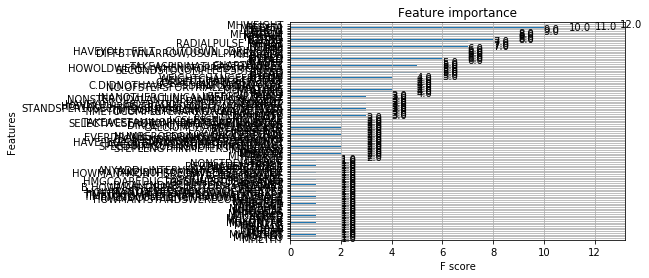

In [31]:
# Train the XGBoost model
train_data = xgb.DMatrix(data=X_train, label=y_train)
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
}
bst = xgb.train(param, train_data)

# Plot feature importance
plot_importance(bst)
plt.show()


In [32]:
# Get feature importance
importance = bst.get_score(importance_type='gain')

# Convert into a pandas dataframe
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Score': list(importance.values())
})

# Sort by the score in descending order
importance_df = importance_df.sort_values(by='Score', ascending=False)

# Display the importance_df dataframe
print(importance_df)


                           Feature       Score
57                          FFFX50  309.385895
27                          MHARTH  265.436737
82   C.DIDNOTHAVE>=5DRINKSONANYDAY  147.097107
104      TAKEASPIRINATLEAST3X/WEEK  103.015160
91                         ASPIRIN   99.368332
..                             ...         ...
32                         MHANKLE    0.478149
106    TAKEIBUPROFINATLEAST3X/WEEK    0.434561
83      D.CALENDARUNITFOR>=9DRINKS    0.414551
50                         MHOTHER    0.408752
23                           MHCHF    0.403076

[125 rows x 2 columns]


In [33]:
# Modify pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the importance_df dataframe
print(importance_df)

# Reset pandas display options to default
pd.reset_option('display.max_rows')

                                       Feature       Score
57                                      FFFX50  309.385895
27                                      MHARTH  265.436737
82               C.DIDNOTHAVE>=5DRINKSONANYDAY  147.097107
104                  TAKEASPIRINATLEAST3X/WEEK  103.015160
91                                     ASPIRIN   99.368332
43                                     MHDIZZY   93.506805
21                                        MHBP   91.364807
110                                CHARTBLTEST   80.795532
90                                ACEINHIBITOR   80.322296
30                                      MHHAND   57.729763
52                                        MHBW   49.895767
34                                      MHKDNY   49.269714
28                                     MHARTDK   39.386940
12                                       B1PED   39.112122
26                                       MHCAT   37.051674
2                                        B1FND   34.6921

In [36]:
# Initiate the IsolationForest model with appropriate parameters
iso_forest = IsolationForest(contamination=0.05)  # the proportion of outliers in the data set

# Fit the model
iso_forest.fit(X)

# Predict the anomalies in the data
outliers = iso_forest.predict(X)  # for each record, returns 1 if inlier and -1 if outlier

# Add the outlier column to your dataframe
X['outlier'] = outliers

# You can then remove the outliers before splitting the data and training the model
X = X[X['outlier'] == 1]
X.drop('outlier', axis=1, inplace=True)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [37]:
# Predict the anomalies in the data
outliers = iso_forest.predict(X)

# Count the number of outliers and inliers
num_outliers = (outliers == -1).sum()
num_inliers = (outliers == 1).sum()

print(f"Number of outliers: {num_outliers}")
print(f"Number of inliers: {num_inliers}")


Number of outliers: 0
Number of inliers: 5694
